In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
df= pd.read_csv('../data/train/D1training.csv')

In [3]:
df.drop(columns=['index','r2_iram1622', 'r3_iram1622', 'r7_iram1622', 'r28_iram1622'], inplace=True)

In [4]:
X = df.drop(columns=["r1_iram1622"])
y = df['r1_iram1622']

In [5]:
# Convertir a tensores para PyTorch
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)  # Agregar dimensión extra para PyTorch


In [6]:
# Crear un DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
# Definir el Generador con mayor capacidad y Dropout
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout del 30%
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

    def forward(self, x):
        return self.model(x)

# Definir el Discriminador con Dropout
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [8]:
# Configuración de dimensiones
latent_dim = 10  # Dimensión del vector de ruido
input_dim = X_tensor.shape[1]
output_dim = 1

# Instanciar Generador y Discriminador
generator = Generator(latent_dim + input_dim, output_dim)
discriminator = Discriminator(input_dim + output_dim)

In [9]:
# Optimizadores con regularización L2
optimizer_G = optim.Adam(generator.parameters(), lr=0.0005, weight_decay=0.01)  # Regularización L2
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, weight_decay=0.01)

# Funciones de pérdida
adversarial_loss = nn.BCELoss()
regression_loss = nn.MSELoss()

In [10]:
# Entrenamiento de la GAN con ajustes
num_epochs = 5000  # Incrementar épocas
for epoch in range(num_epochs):
    for real_data, target in dataloader:
        batch_size = real_data.size(0)

        # Etiquetas reales y falsas con ruido
        real_labels = torch.ones((batch_size, 1)) * 0.9  # Etiquetas reales con ruido
        fake_labels = torch.zeros((batch_size, 1)) + 0.1  # Etiquetas falsas con ruido

        # ---------------------
        #  Entrenamiento del Discriminador
        # ---------------------
        optimizer_D.zero_grad()

        # Datos reales
        real_input = torch.cat((real_data, target), dim=1)
        real_output = discriminator(real_input)
        real_loss = adversarial_loss(real_output, real_labels)

        # Datos falsos
        noise = torch.randn(batch_size, latent_dim)
        fake_input = torch.cat((real_data, noise), dim=1)
        fake_data = generator(fake_input).detach()
        fake_input_combined = torch.cat((real_data, fake_data), dim=1)
        fake_output = discriminator(fake_input_combined)
        fake_loss = adversarial_loss(fake_output, fake_labels)

        # Pérdida total del discriminador
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Entrenamiento del Generador
        # ---------------------
        for _ in range(5):  # Entrenar al generador más veces
            optimizer_G.zero_grad()
            fake_data = generator(fake_input)
            fake_input_combined = torch.cat((real_data, fake_data), dim=1)
            fake_output = discriminator(fake_input_combined)

            # Función de pérdida híbrida
            g_loss = adversarial_loss(fake_output, real_labels) + 1.0 * regression_loss(fake_data, target)

            g_loss.backward()
            optimizer_G.step()

    # Imprimir pérdidas cada 100 épocas
    if epoch % 100 == 0:
        print(f"Época {epoch} - Pérdida D: {d_loss.item():.4f}, Pérdida G: {g_loss.item():.4f}")




Época 0 - Pérdida D: 1.4289, Pérdida G: 34.1231
Época 100 - Pérdida D: 1.4010, Pérdida G: 5.7214
Época 200 - Pérdida D: 1.3911, Pérdida G: 2.7134
Época 300 - Pérdida D: 1.3910, Pérdida G: 2.0048
Época 400 - Pérdida D: 1.3822, Pérdida G: 2.0239
Época 500 - Pérdida D: 1.3801, Pérdida G: 1.7724
Época 600 - Pérdida D: 1.3839, Pérdida G: 1.1847
Época 700 - Pérdida D: 1.3877, Pérdida G: 1.1603
Época 800 - Pérdida D: 1.3848, Pérdida G: 1.1842
Época 900 - Pérdida D: 1.3869, Pérdida G: 0.9369
Época 1000 - Pérdida D: 1.3862, Pérdida G: 1.1464
Época 1100 - Pérdida D: 1.3867, Pérdida G: 0.9694
Época 1200 - Pérdida D: 1.3866, Pérdida G: 1.1539
Época 1300 - Pérdida D: 1.3867, Pérdida G: 1.1272
Época 1400 - Pérdida D: 1.3863, Pérdida G: 1.0416
Época 1500 - Pérdida D: 1.3863, Pérdida G: 0.9983
Época 1600 - Pérdida D: 1.3863, Pérdida G: 1.1347
Época 1700 - Pérdida D: 1.3863, Pérdida G: 1.0744
Época 1800 - Pérdida D: 1.3863, Pérdida G: 1.0217
Época 1900 - Pérdida D: 1.3863, Pérdida G: 1.0883
Época 2000 

In [11]:
# Generar datos nuevos con el Generador entrenado
def generate_predictions(generator, X, latent_dim):
    generator.eval()
    noise = torch.randn(X.shape[0], latent_dim)
    input_combined = torch.cat((X, noise), dim=1)
    with torch.no_grad():
        predictions = generator(input_combined)
    return predictions.numpy()

In [12]:
# Generar predicciones para los datos de entrada
predicted_values = generate_predictions(generator, X_tensor, latent_dim)
print("Predicciones generadas:", predicted_values)

Predicciones generadas: [[19.331697]
 [17.623293]
 [17.08415 ]
 [17.2572  ]
 [18.236242]
 [17.33803 ]
 [16.875378]
 [22.003208]
 [15.834954]
 [16.344572]
 [16.153574]
 [16.975302]
 [23.094036]
 [20.023188]
 [20.564106]
 [18.877863]
 [19.919956]
 [19.713636]
 [20.214811]
 [18.927298]
 [19.382473]
 [18.498487]
 [18.854872]
 [17.133892]
 [18.562836]
 [15.344664]
 [17.636688]
 [17.03271 ]
 [17.030136]
 [17.251167]
 [17.037792]
 [17.438896]
 [17.568127]
 [16.81786 ]
 [17.203268]
 [18.196928]
 [18.737875]
 [16.350664]
 [16.683657]
 [15.85518 ]
 [20.3139  ]
 [16.82512 ]
 [17.199879]
 [18.923513]
 [21.94201 ]
 [19.548096]
 [18.715727]
 [19.475021]
 [18.151484]
 [19.065628]
 [22.359503]
 [19.542576]
 [17.355225]
 [18.51718 ]
 [21.199747]
 [14.002701]
 [22.251633]
 [21.662306]
 [20.29082 ]
 [17.755724]
 [20.226635]
 [21.323748]
 [20.70576 ]
 [22.899672]
 [19.303032]
 [20.491076]
 [19.345482]
 [20.698826]
 [18.095938]
 [17.981571]
 [17.20244 ]
 [16.234602]
 [19.315027]
 [18.187172]
 [17.846264]
 

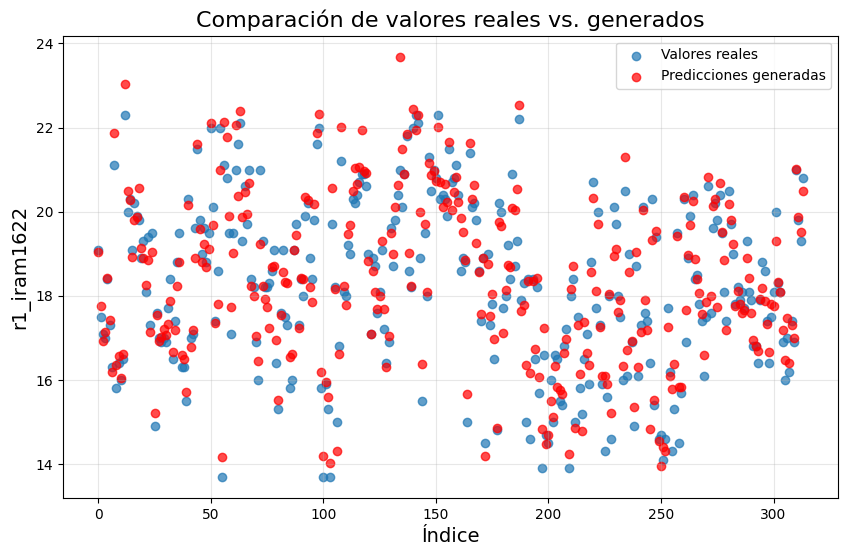

In [13]:
# Generar predicciones usando el generador entrenado
predicted_values = generate_predictions(generator, X_tensor, latent_dim)

# Restaurar las predicciones a su rango original
predicted_values = predicted_values.flatten()
real_values = y_tensor.numpy().flatten()

# Visualizar las predicciones frente a los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(range(len(real_values)), real_values, label="Valores reales", alpha=0.7)
plt.scatter(range(len(predicted_values)), predicted_values, label="Predicciones generadas", alpha=0.7, color='red')
plt.title("Comparación de valores reales vs. generados", fontsize=16)
plt.xlabel("Índice", fontsize=14)
plt.ylabel("r1_iram1622", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

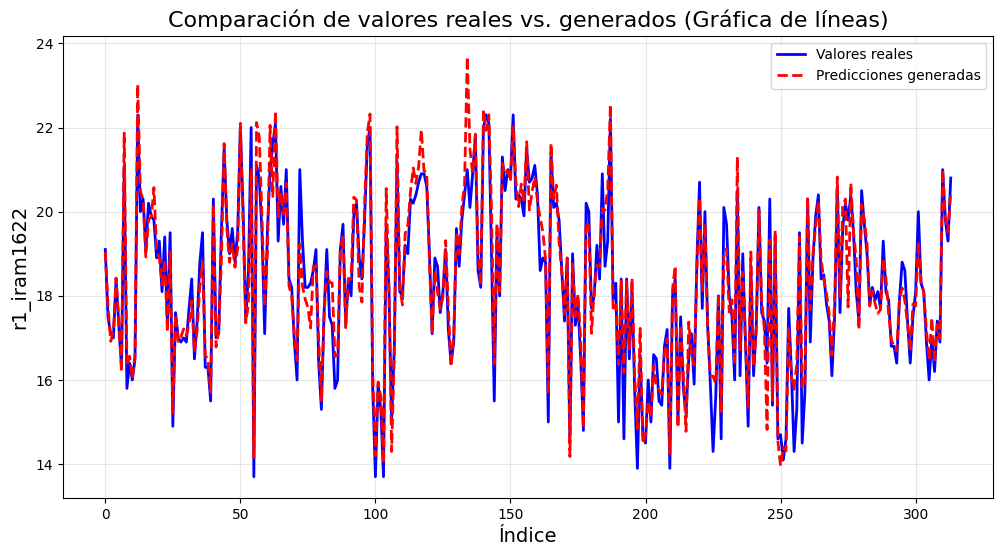

In [14]:
# Visualizar las predicciones frente a los valores reales con líneas
plt.figure(figsize=(12, 6))
plt.plot(real_values, label="Valores reales", color="blue", linewidth=2)
plt.plot(predicted_values, label="Predicciones generadas", color="red", linestyle="--", linewidth=2)
plt.title("Comparación de valores reales vs. generados (Gráfica de líneas)", fontsize=16)
plt.xlabel("Índice", fontsize=14)
plt.ylabel("r1_iram1622", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [15]:
# 1. Cargar el dataset de test
test_data = pd.read_csv('../data/test/D1test.csv')

In [16]:
X_test = test_data.drop(columns=['index',"r1_iram1622",'r2_iram1622','r3_iram1622','r7_iram1622','r28_iram1622'])
y_test = test_data['r1_iram1622']

In [17]:
X_test

,g45µ,sba,pf,so3,mgo,sio2,fe2o3,caot,al2o3,na2o,k2o
0,-0.269673,2.092345,1.799656,0.227179,-0.482988,-1.109238,-0.883245,1.055813,-1.408923,-1.09744,-0.365133
1,1.803458,0.469857,0.878842,1.329356,0.059409,-0.665443,0.195371,1.717601,-0.722943,-1.09744,0.097375
2,0.574936,1.078290,0.418435,0.668050,0.113648,-0.639338,0.432141,1.748622,-0.619007,-1.09744,0.123070
3,-0.461629,1.838831,2.444225,-0.066735,-0.049071,-1.083133,-0.699091,0.518110,-1.055540,-1.09744,-0.133879
4,-0.730368,1.737426,0.798270,0.521093,0.059409,-0.752462,0.589987,0.135513,-0.826880,-1.09744,-0.056794
...,...,...,...,...,...,...,...,...,...,...,...
74,0.613327,-1.051226,1.569452,-1.242391,-0.482988,-0.978710,-0.436014,0.859344,-0.847667,-0.90076,-0.108184
75,0.536545,-0.138576,1.650023,0.521093,-0.374509,-0.865586,-0.699091,0.911046,-0.660582,-0.90076,-0.031099
76,-0.173694,-0.138576,1.316228,-0.287170,-0.374509,-0.830779,-0.620168,1.055813,-0.743731,-1.09744,-0.108184
77,-0.346455,-0.696307,1.005454,-0.507606,-0.537228,-0.795971,0.142756,0.973089,-0.764518,-1.09744,-0.236658


In [18]:
# 3. Convertir X_test a tensores
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [19]:
# 4. Usar el generador para predecir valores
predicted_test_values = generate_predictions(generator, X_test_tensor, latent_dim)
predicted_test_values = predicted_test_values.flatten()

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [21]:
# 5. Calcular métricas de evaluación
mae = mean_absolute_error(y_test, predicted_test_values)
rmse = np.sqrt(mean_squared_error(y_test, predicted_test_values))
r2 = r2_score(y_test, predicted_test_values)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

MAE: 1.5744
RMSE: 1.9666
R2 Score: -0.5297


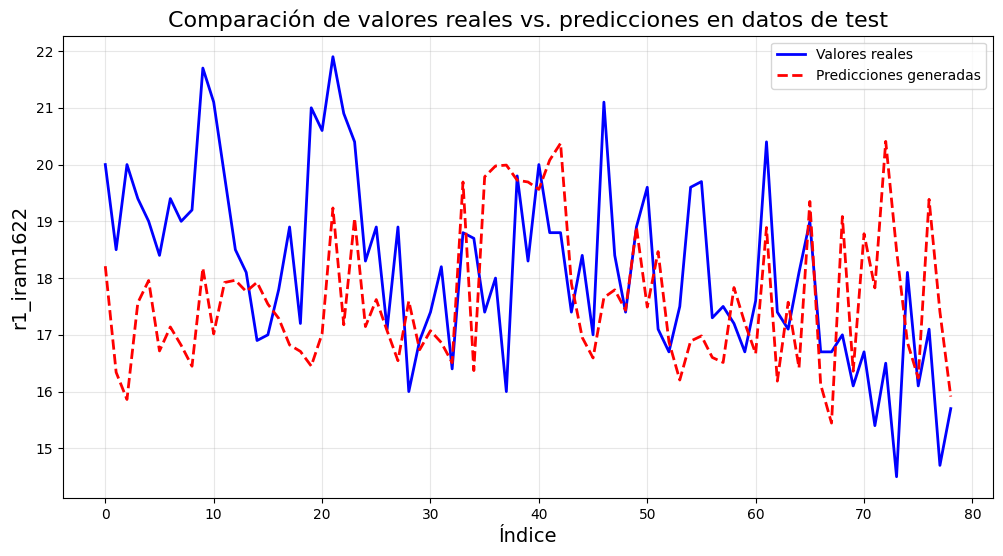

In [22]:
# 6. Visualizar las predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Valores reales", color="blue", linewidth=2)
plt.plot(predicted_test_values, label="Predicciones generadas", color="red", linestyle="--", linewidth=2)
plt.title("Comparación de valores reales vs. predicciones en datos de test", fontsize=16)
plt.xlabel("Índice", fontsize=14)
plt.ylabel("r1_iram1622", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()